<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# RECITATION 2: Error Propagation & Fourier Analysis
---
<!--end-block-->

<!--start-block-->

## 2.0 Overview of Learning Objectives

In this recitation we will explore the following objectives:

- Understand error propagation
- Propagate Gaussian errors through arbitrary functions using Numpy
- Understand the frequency analysis of continuous and discrete time signals
- Visualize the connection between time and frequency space
- Characterize the energy/power carried by different frequencies
- Filter and denoise a signal by visualizing its spectral content

<br>
The following installation commands may come in handy:

conda install numpy scipy matplotlib lmfit pyaudio

pip3 install https://sigproc.mit.edu/_static/fall21/software/lib6003-0.0.4.tar.gz
<!--end-block-->

----
## 2.1 Error Propagation

## 2.1.0 Motivation: Lab Reports and Beyond
- We often encounter functions of measured quantities with associated independent Gaussian errors
- Often these functions can be treated with standard error propagration: $ \Delta f(\{x_i\}) = \sqrt{\sum_i (\partial f / \partial x_i)^2 (\Delta x_i)^2} $
- Sometimes things get complicated
    - A good physicist is (somewhat) lazy
- We can use NumPy to help us propagate errors through more complex functions

## 2.1.1 A (Very) Simple Example

Suppose we have data points ($x,y$) with independent gaussian errors $\Delta x$ and $\Delta y$. We want to compute $f(x,y) = x + y$ and its error.

Using our error propagation formula above we obtain: $\Delta f = \sqrt{(\Delta x)^2 + (\Delta y)^2} $

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

def f(x, y):
    return x + y

def delta_f(delta_x, delta_y):
    return np.sqrt((delta_x**2.)+(delta_y**2.))

x_val = 5.
x_err = 2.

y_val = 9.
y_err = 2.

print("f(x) = %f +/- %f" % (f(x_val, y_val), delta_f(x_err, y_err)))


f(x) = 14.000000 +/- 2.828427


Now let's try using NumPy to run actual gaussian distributions through this function

f(x) = 13.998440 +/- 2.817701


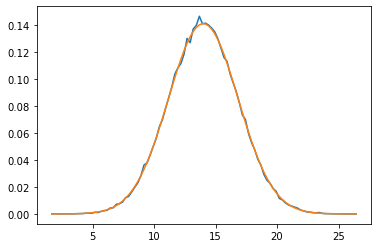

In [2]:
np.random.seed(2)
N_SAMPLES = 100000
N_BINS = 100
x_samples = np.random.normal(loc = x_val, scale = x_err, size = N_SAMPLES)
y_samples = np.random.normal(loc = y_val, scale = y_err, size = N_SAMPLES)

f_samples = f(x_samples, y_samples)

counts, bin_edges = np.histogram(f_samples, bins = N_BINS, density = True)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])

plt.plot(bin_centers,counts)
plt.plot(bin_centers, scipy.stats.norm.pdf(bin_centers, loc = f(x_val, y_val), scale = delta_f(x_err, y_err)))

print("f(x) = %f +/- %f" % (np.mean(f_samples), np.std(f_samples)))


## 2.1.2 A More Complicated Example

Now let's take $g(x,y) = (\sqrt{|x|} + \sqrt{|y|})\cdot (x - y)$

### <span style="color: red"> >>> QUESTION 2.1: </span>
Fill in the following code cell to compute the error on g using the same values of $x$ and $y$ (and their respective errors) from before:

<!--
ANSWER:

np.random.seed(2)
N_SAMPLES = 100000
N_BINS = 100

def g(x,y):
    return (np.sqrt(np.abs(x))+np.sqrt(np.abs(y)))*(x-y)

####################
# Insert Code Here #
####################

g_samples = g(x_samples, y_samples)
g_val = np.mean(g_samples)
g_err = np.std(g_samples)


counts, bin_edges = np.histogram(g_samples, bins = N_BINS, density = True)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])

plt.plot(bin_centers,counts)

print("g(x) = %f +/- %f" % (g_val, g_err))

-->

g(x) = -20.437936 +/- 14.358070


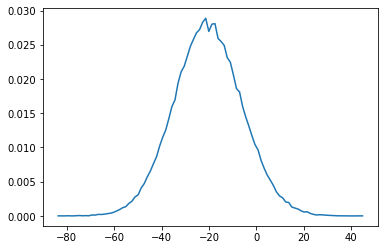

In [4]:
np.random.seed(2)
N_SAMPLES = 100000
N_BINS = 100

def g(x,y):
    return (np.sqrt(np.abs(x))+np.sqrt(np.abs(y)))*(x-y)

####################
# Insert Code Here #
####################

g_samples = g(x_samples,y_samples) # Placeholder Value - Fill in the correct line
g_val = np.mean(g_samples) # Placeholder Value - Fill in the correct line
g_err = np.std(g_samples) # Placeholder Value - Fill in the correct line

####################

counts, bin_edges = np.histogram(g_samples, bins = N_BINS, density = True)
bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])

plt.plot(bin_centers,counts)

print("g(x) = %f +/- %f" % (g_val, g_err))


## 2.1.3 Johnson Noise
Let's apply this to something slightly more useful, such as measuring the Boltzmann constant. We can use Johnson Noise (the thermal noise across a resistor), which is defined by:

$$\frac{V^2}{4 T} = k_B R\int_{0}^{\infty} \frac{g(f)^2}{1+ (2\pi R C f)^2}$$

Suppose we measured $g$ as a function of $f$, and we have some uncertainties on $R$ and $C$. Let's compute the total uncertainty on this complicated quantity


In [5]:
frequency = np.array([   200.,    300.,    400.,    500.,    600.,    700.,    800.,
          900.,   1000.,   1100.,   1200.,   1300.,   1400.,   1500.,
         1700.,   2000.,   3000.,   4000.,   5000.,   7000.,  10000.,
        13000.,  15000.,  17000.,  20000.,  25000.,  30000.,  35000.,
        40000.,  45000.,  50000.,  55000.,  60000.,  65000.,  70000.,
        75000.,  80000.,  85000.,  90000.,  95000., 100000.])

gain = np.array([  1.56572199,   7.56008454,  24.23507344,  58.36646477,
       119.11924863, 215.75587662, 354.79343025, 517.34083494,
       679.81395988, 805.18954729, 877.53623188, 944.14612835,
       951.12203586, 981.66551215, 976.08071562, 971.57565072,
       991.33195051, 974.54482165, 968.02100388, 970.96127868,
       972.70192708, 980.9122768 , 983.62597547, 981.85446382,
       964.75994752, 984.27991886, 959.44478862, 975.87335094,
       906.24841379, 831.8699187 , 695.5940221 , 562.69096627,
       426.50959034, 328.93671408, 248.14630158, 198.16023325,
       150.59357167, 121.00349255, 100.86777721,  79.42663031,
        63.20952534])

gain_uncertainty = np.array([5.21317443e-03, 3.11522352e-02, 1.17453781e-01, 1.54063502e-01,
       1.27335068e+00, 1.27124575e+00, 1.62862522e+00, 8.07632112e-01,
       1.39800408e+00, 1.52872753e+00, 9.26100943e-01, 2.07700290e+00,
       2.41624111e+00, 2.48737608e+00, 2.66446131e+00, 6.30956544e+00,
       2.48543922e+00, 5.85031911e+00, 5.36245736e+00, 5.03316166e+00,
       5.96042863e+00, 1.80119083e+00, 2.19189309e+00, 4.76416499e+00,
       2.60518705e+00, 8.91016625e-01, 8.68517783e-01, 7.60893395e-02,
       1.12595429e+00, 9.59211786e-01, 2.11207039e+00, 1.54206027e+00,
       6.15658573e-01, 2.21068956e+00, 1.93131996e+00, 1.17159272e+00,
       1.02084395e+00, 6.45939329e-01, 1.15822783e+00, 1.50426555e-01,
       2.64213908e-01])

resistance = np.array([477.1e3, 810e3, 99.7e3, 502.3e3, 10.03e3]) 
resistance_uncertainty = np.array([0.2e3, 2e3, 0.2e3, 0.3e3, 0.3e3])

capacitance = 125e-12
capacitance_uncertainty = 14e-12

v2rmsd4t = np.array([2.57337556e-08, 1.96214066e-08, 2.21758082e-08, 2.38320749e-08,
       7.31633110e-09])
v2rmsd4t_uncertainty = np.array([1.25267830e-09, 1.46644504e-09, 1.08426579e-09, 1.77538860e-09,
       2.07583938e-10])

<ErrorbarContainer object of 3 artists>

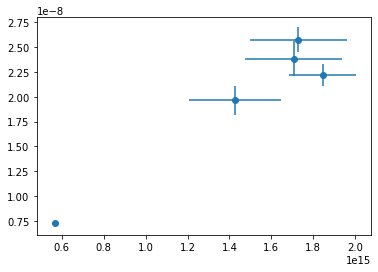

In [6]:
from scipy.integrate import trapz

def mc_compute(freq, gain, gain_error, r, rerr, cap, cap_err, n_samp):
    samples = []
    for k in range(n_samp):
        mc_gain = gain + np.random.normal(len(gain))*gain_error
        mc_r = r + rerr*np.random.normal(1)
        mc_cap = cap + cap_err*np.random.normal(1)
        mc_integrand = mc_gain**2.0/(1+ (2*np.pi*mc_r*mc_cap*freq)**2.0)
        mc_int = scipy.integrate.trapz(mc_integrand, freq)
        samples.append(mc_r*mc_int)
    return np.array(samples)


rgr = []
rgr_unc = []
for k in range(5):
    samples = mc_compute(frequency, gain, gain_uncertainty, resistance[k], resistance_uncertainty[k], capacitance, capacitance_uncertainty,10000)
    rgr.append(np.mean(samples))
    rgr_unc.append(np.std(samples))
rgr = np.array(rgr)  
rgr_unc = np.array(rgr_unc)


plt.errorbar(rgr, v2rmsd4t, yerr = v2rmsd4t_uncertainty, xerr= rgr_unc, fmt = 'o' )

[[Model]]
    Model(linear_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 5
    # variables        = 2
    chi-square         = 2.18039779
    reduced chi-square = 0.72679926
    Akaike info crit   = -0.14965290
    Bayesian info crit = -0.93077707
[[Variables]]
    k:  1.35619051 +/- 0.10412943 (7.68%) (init = 1)
    b:  0.02921130 +/- 0.04566742 (156.33%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = 0.954


<AxesSubplot:title={'center':'Model(linear_model)'}, xlabel='x', ylabel='y'>

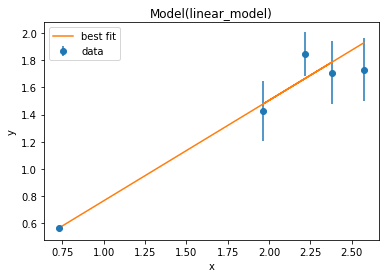

In [7]:
from lmfit.models import Model

def linear_model(x, k, b):
    return x/k+b

lmod = Model(linear_model)
lmod.set_param_hint(name = 'k', value = 1)
lmod.set_param_hint(name = 'b', value = 1)
result = lmod.fit(1e-15*rgr, x = v2rmsd4t*1e8, weights = 1/(rgr_unc*1e-15))
print(result.fit_report())
result.plot_fit()

<!--start-block-->
----
## 2.2.0 Motivation: Gravitational Waves/LIGO 

- Every massive object that accelerates produces gravitational waves. 
- These can be intuitively understood as "ripples" in space-time that travel at the speed of light. 
- Continuous gravitational waves are thought to be produced by spinning massive objects like a neutron star. 
- Compact Binary Inspiral Gravitational Waves are of particular interest and show up as significant detections in LIGO 
    - Binary Neutron Stars (BNS)
    - Binary Black Hole (BBH)
    - Neutron Star-Black Hole Binary (NSBH)


<br>
<!--end-block-->

<img src='assets/images/ligo.jpg' alt="drawing" width="700"/>

- Measured on Earth, cataclysmic mergers change the length of a 4km LIGO arm by a thousandth of the width of a proton. 
- Strain is the instrument's detected space change within an arm in comparison to the total space (length) of the arm. 
- In the event of a detectable merger this strain data will form a "gravitational wave signal".

<!--start-block-->
<hr style="height: 1px;">

## 2.2 Frequency Analysis

<img src='assets/images/strain.png' />

- Is there another way of thinking about our data, in a way that may be more useful for our particular application? 
- If time-series data is too noisy/messy for easy analysis, we can consider the underlying frequency representation of the same information.

**Fourier Transform**<br />
*Space or Time Functions* &rarr; *Spatial or Temporal Frequencies* <br />
**Inverse Fourier Transform**<br />
*Spatial or Temporal Frequencies* &rarr; *Space or Time Functions*

### What do I mean by "Frequency Space", 

- In 1807 Joseph Fourier posited that any periodic signal could be represented by a sum of a particular set of harmonic sinusoids. 
- i.e. all signals can be decomposed into elemental sine and cosine components
$$f(t) = c_0 + \sum\limits_{k=1}^\infty (c_k\cos(k\omega_o t) + d_k\sin(k\omega_o t))$$

<br>
<!--end-block-->

<img src='assets/images/decompose.gif'>

<img src='assets/images/recompose.gif'>

<!--start-block-->
#### <span style="color:red">>>> QUESTION 2.2</span>


Convince yourself that the follwing sinusoidal decomposition is indeed the case.
$$e^{ix} = \cos(x) + i\sin(x)$$
<img src='assets/images/plane.png'>

<br>
<!--end-block-->

<img src='assets/images/sawtooth.gif'>

<!--start-block-->
<hr style="height: 1px;">

## 2.3 The Discrete Fourier Transform

***Overview***
- These decomposed sinusoids are characterized by their frequencies.
- Want a mathematical machine that treats signals with a given frequency different than other frequencies. 

***Analysis (Discrete Fourier Transform)***
- We can inspect a signal and ask how much of one frequency is present.
- Multiply our signal by a sinusoid of a particular frequency to ask how "similar" the two are. 
- Call these the *Fourier frequency coefficients.*
$$ X[k] = \frac{1}{N}\sum\limits_{n=1}^{N-1} x[n]e^{-i\frac{2\pi k}{N} n} $$ 
<br>

| Syntax      | Description |
| ----------- | ----------- |
| $ x[n]$ | Signal for analysis |
| $ e^{-i\frac{2\pi k}{N} n}$ | Frequency component k we compare to |
| $ X[k] $ | How similar to the sinusoid of component k |

$$X[k] = \frac{1}{N}\sum\limits_{n=1}^{N-1} (e^{-i\frac{2\pi j}{N} n})(e^{i\frac{2\pi k}{N} n}) = \frac{N}{N}\delta_{jk} $$ 
<br>

***The "DC" ($X[0]$) Term***
- Is the 0 frequency component of a signal.
- Represents the constant offset of a signal (if any). 
- Represents the *average value* of a signal over one period. 


***Synthesis (Inverse Discrete Fourier Transform)***
- Can recompose signal with these coefficients.
$$x[n] = \sum\limits_{k=0}^{N-1}X[k]e^{i\frac{2\pi k}{N} n}$$

<img src = 'assets/images/box_transform.PNG'>
<img src = 'assets/images/box_transform_2.PNG'>

- Notice that when we tightened our signal in time, we made it wider in frequency. This is a visual representation of the famous _uncertainity principle_! It arises in quantum mechanics because position and momentum obey the same Fourier relationship that time and frequency do above.

<!--start-block-->
<hr style="height: 1px;">

## 2.4 Spectral Density/Power Spectrums


##### First the Energy Spectral Density (ESD)
- Describes how the energy of a signal is distributed with frequency. 
- The squared magnitude of each frequency 
- Good for localised transients (pulse-like signals) whose energy is concentrated around one time window. 
$$\overline{S}_{xx}(f) = |{\hat{x}(f)}|^2$$

#####  Power Spectral Density (PSD)
- For continuous signals over all time, the power spectal density is more apt. 
- The power spectral density of a time series is the measure of the signal's power content in the frequency components that compose that signal.
$$S_{xx}(f) = \lim_{T \to \infty} \frac{1}{T}|\hat{x}_T(f)|^2 \ \textrm{where} \ x_T \ \textrm{is the signal, windowed}$$
$$S_{xx}(f) = \int_{-\infty}^{\infty} R_{xx}(\tau)e^{-i2\pi f\tau}d\tau = \hat{R}_{xx}(f) $$
- Defined as the normalized limit of the ESD for the windowed signal.
- Also represented as the Fourier transform of the autocorrelation function $R_{xx}(\tau)$ (informally, the Fourier transform of how similar the signal is to itself). 

#####  Amplitude Spectral Density (PSD)
- Amplitude Spectral Density (ASD) is just the square-root of the PSD and is useful when the shape of the spectrum is rather constant, since variations in the ASD will then be proportional to variations in the signal's voltage itself.

<img src = 'assets/images/spectrum.png'>

- Dominated by low frequencies and sharp spectral lines throughout. 
- From instrumental artifacts
    - Seismic noise
    - "Violin Modes" from the suspension fibers of the LIGO mirrors. 

<!--start-block-->
<hr style="height: 1px;">

## 2.5 Spectrograms Q-Transform
- To better understand a system, we can bridge the gap between the frequency and time domains with another transform.
- The Short-Time Fourier Transform takes the Fourier transform within shorter time segments. 
- The resulting visual representation is called a "spectrogram" which can be thought of as a series of Fourier transforms stacked on their side. 

<img src = 'assets/images/motif_sgram.png'>

- The Q-Transform breaks these intervals up with logarithmic spacing for when the data are better represented as such (often times in audio.)

<img src = 'assets/images/stft_vs_q_gautham.png'>
<!-- https://ccrma.stanford.edu/~gautham/Site/Multipitch.html -->

#### Whitening data
- From the ASD above, we can see that noise fluctuations are much larger at low and high frequencies and near spectral lines. 
- To better visualize deviations from the noise, it is useful to employ a technique called "whitening".
- Whitening takes the data and attempts to make the power spectral density flat (i.e. normalize the power at all frequencies) so that excess power at any frequency is more obvious. 

- Persisent signals like noise will have their power spread about the entire time window. 
- Localized signals will have all of their power in one region region (evident spikes)

- Achieved very informally by applying the inverse frequency response of the raw signal. 

Example: Trasmitted power in one of the interferoeter arms with two large glitches with a frequency around 5-50Hz

<img src = 'assets/images/whiteningexample_gwpy.png'>


#### Filtering
- The amplification/attenuation of frequency components.
- Can be done in the time domian but best viewed from the frequency domain. 
    - **Multiplication in the frequency domain**
    - A set of scale factors H() which is refered to as the frequency response of the system.
<img src ='assets/images/filters.png'>


In [ ]:
#Import Packages
import math
import numpy as np
import lib6003
import matplotlib.pyplot as plt
from lib6003.audio import wav_write
from lib6003.audio import wav_file_play
from lib6003.audio import wav_read
from lib6003.audio import wav_play
from lib6003.fft import fft
from lib6003.fft import ifft
from scipy.io.wavfile import write

##### DFT Filtering
- We can filter using DFT coefficients by scaling them appropriately.

In [ ]:
#Noise-Free #3 
wav_file_play('assets/audio/ocean_man_raw.wav')

###### Bass Boosting

In [ ]:
x,fs =wav_read('assets/audio/ocean_man_raw.wav')
## x is the data, fs is the sampling frequency
N = len(x)
## f = k*fs/N
## k = f*N/fs
fc = 400 #cutoff frequency in Hz; boost all frequency content below fc
kc = int(fc*N/fs)

X = fft(x)
Y = X[:] #copy values from X
Y[:kc] = [i*5 for i in X[:kc]]
Y[-kc:] = [i*5 for i in X[-kc:]]
## Amplify all the coefficients in the bass-boosted region by 5

## Inverse fourier transform and recombine into a .wav file 
y = ifft(Y)
# assert all(abs(i.imag) < 1e-12 for i in y)
wav_play([i.real for i in y],fs)

###### Bass Isolation (Low Pass)

In [ ]:
x,fs = wav_read('assets/audio/ocean_man_raw.wav')
N = len(x)
## f = k*fs/N
## k =f*N/fs
fc = 400  # cutoff frequency in Hz; boost all frequency content below fc
kc = int(fc*N/fs)

X = fft(x)
Y = X[:] # copy values from X
Y[kc:-kc] = [i*0 for i in X[kc:-kc]]

y = ifft(Y)
# assert all(abs(i.imag) < 1e-12 for i in y)
wav_play([i.real for i in y],fs)

#### Signal Detection and Matched Filtering
- If we have an unknown, noisy signal we can try to detect the presence of a known signal with matched filtering. 
- If we *know* or *guess* the signal we're looking for (called the *template*), we can use it as a filter for combing the data for the presence of that template.
- Matched filters work by maximizing the signal to noise ratio (SNR) when the matched filter detects the presence of the template signal in a noisy signal. 
- Phil will talk more about convolutions next week but we can informally think of a matched filter as:
- "Drag" or sweep your template across the signal and calculate some statistic.
- The optimal statistic suggests the presence of a signal. 

<img src ='template.png'>
<img src ='SNR.png'>


In [ ]:
#Noise-Free 
wav_file_play('assets/audio/ocean_man_raw.wav')

In [ ]:
#Noise
wav_file_play('assets/audio/ocean_man.wav')

In [ ]:
#Read in Data
data, samp_rate = wav_read('assets/audio/ocean_man.wav')
#Check length of Data
N = len(data)
#Take the Fourier Transform
dft_cof = fft(data)
k = np.linspace(0,N-1,N)
f=k*samp_rate/N

plt.plot(f,np.absolute(dft_cof))
plt.title("Noisty Ocean Man Spectrum", fontsize=18)
plt.xlabel('Frequency $\\nu $', fontsize=14)
plt.ylabel('Magnitude $|X(\\nu)|$', fontsize=14)
plt.show()



In [ ]:
#Focus in on one set of conjuagte frequencies
plt.plot(f,np.absolute(dft_cof))
plt.xlim(-100,5000)
plt.ylim(0,0.01)
plt.title("Noisy Ocean Man Spectrum", fontsize=18)
plt.xlabel('Frequency $\\nu $', fontsize=14)
plt.ylabel('Magnitude $|X(\\nu)|$', fontsize=14)
plt.show()

In [ ]:
#Zoom in on artifact
plt.plot(f,np.absolute(dft_cof))
plt.xlim(980,1000)
plt.ylim(0,0.008)
plt.title("Noisy Ocean Man Spectrum", fontsize=18)
plt.xlabel('Frequency $\\nu $', fontsize=14)
plt.ylabel('Magnitude $|X(\\nu)|$', fontsize=14)
plt.show()

In [ ]:
k_cut = int((990*N/samp_rate))
# print(k_cut)
freqs = fft(data)
# print(len(freqs))
for i in range(k_cut-100,k_cut+100):
    freqs[i]= 0
for i in range(-k_cut-100,-k_cut+100):
    freqs[i]= 0
# print(len(freqs))
f=k*samp_rate/N

plt.title("Denoised Ocean Man Spectrum", fontsize=18)
plt.xlabel('Frequency $\\nu $', fontsize=14)
plt.ylabel('Magnitude $|X(\\nu)|$', fontsize=14)

plt.plot(f,np.absolute(freqs))
plt.show()


In [ ]:
ocean_fix = ifft(freqs)
wav_play(ocean_fix,samp_rate)

<img src ="assets/images/xkcd.jpg">